# 02 — GraphSAGE on Cora (PyTorch Geometric)

In this notebook we train a **GraphSAGE** model on the Cora citation network using PyTorch Geometric.

Goals:

- Implement a 2-layer GraphSAGE encoder for node classification
- Compare its performance with the GCN baseline
- Visualize learned node embeddings with UMAP
- Save model and embeddings to `artifacts/cora_graphsage` for ater use


In [1]:
import os
from pathlib import Path

# Safer linear algebra threading on Windows
os.environ["MKL_THREADING_LAYER"] = "SEQUENTIAL"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam

from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import SAGEConv

import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Paths ---
CWD = Path.cwd()
print("CWD:", CWD)

PROJECT_ROOT = CWD.parents[0]
print("PROJECT_ROOT:", PROJECT_ROOT)

DATA_ROOT = PROJECT_ROOT / "data" / "Planetoid"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts" / "cora_graphsage"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_ROOT:", DATA_ROOT)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)

Torch: 2.5.1
CUDA available: True
Using device: cuda
CWD: D:\ML\GNN\notebooks
PROJECT_ROOT: D:\ML\GNN
DATA_ROOT: D:\ML\GNN\data\Planetoid
ARTIFACTS_DIR: D:\ML\GNN\artifacts\cora_graphsage


In [2]:
dataset = Planetoid(
    root=DATA_ROOT.as_posix(),
    name="Cora",
    transform=NormalizeFeatures(),
)

print(dataset)
print("Num features:", dataset.num_features)
print("Num classes:", dataset.num_classes)

data = dataset[0].to(device)
print(data)

Cora()
Num features: 1433
Num classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [3]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr="mean")
        self.conv2 = SAGEConv(hidden_channels, out_channels, aggr="mean")
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = GraphSAGE(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    dropout=0.5,
).to(device)

optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(model)

GraphSAGE(
  (conv1): SAGEConv(1433, 64, aggr=mean)
  (conv2): SAGEConv(64, 7, aggr=mean)
)


In [4]:
def train_step(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


@torch.no_grad()
def eval_step(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    def acc(mask):
        correct = pred[mask].eq(data.y[mask]).sum().item()
        total = int(mask.sum())
        return correct / total

    train_acc = acc(data.train_mask)
    val_acc = acc(data.val_mask)
    test_acc = acc(data.test_mask)
    return train_acc, val_acc, test_acc

In [5]:
num_epochs = 200

best_val_acc = 0.0
best_test_at_val = 0.0
best_state_dict = None

history = {
    "epoch": [],
    "loss": [],
    "train_acc": [],
    "val_acc": [],
    "test_acc": [],
}

for epoch in tqdm(range(1, num_epochs + 1), desc="Training GraphSAGE"):
    loss = train_step(model, data, optimizer)
    train_acc, val_acc, test_acc = eval_step(model, data)

    history["epoch"].append(epoch)
    history["loss"].append(loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["test_acc"].append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_at_val = test_acc
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | "
            f"loss={loss:.4f} | "
            f"train={train_acc:.3f} | "
            f"val={val_acc:.3f} | "
            f"test={test_acc:.3f}"
        )

print("\nBest val acc: ", round(best_val_acc, 4))
print("Test acc @best:", round(best_test_at_val, 4))

# сохраняем лучшую модель на диск
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    torch.save(best_state_dict, ARTIFACTS_DIR / "model_graphsage_best.pt")
    print("Saved best model to:", ARTIFACTS_DIR / "model_graphsage_best.pt")

Training GraphSAGE:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001 | loss=1.9494 | train=0.143 | val=0.316 | test=0.319
Epoch 010 | loss=1.5972 | train=1.000 | val=0.736 | test=0.716
Epoch 020 | loss=0.7599 | train=0.993 | val=0.766 | test=0.786
Epoch 030 | loss=0.2589 | train=1.000 | val=0.776 | test=0.808
Epoch 040 | loss=0.1378 | train=1.000 | val=0.776 | test=0.805
Epoch 050 | loss=0.1220 | train=1.000 | val=0.762 | test=0.794
Epoch 060 | loss=0.1164 | train=1.000 | val=0.770 | test=0.792
Epoch 070 | loss=0.1137 | train=1.000 | val=0.770 | test=0.796
Epoch 080 | loss=0.0927 | train=1.000 | val=0.774 | test=0.802
Epoch 090 | loss=0.0846 | train=1.000 | val=0.774 | test=0.796
Epoch 100 | loss=0.0789 | train=1.000 | val=0.776 | test=0.797
Epoch 110 | loss=0.0828 | train=1.000 | val=0.772 | test=0.792
Epoch 120 | loss=0.0633 | train=1.000 | val=0.766 | test=0.792
Epoch 130 | loss=0.0600 | train=1.000 | val=0.762 | test=0.788
Epoch 140 | loss=0.0722 | train=1.000 | val=0.762 | test=0.790
Epoch 150 | loss=0.0639 | train=1.000 | val=0.762 | tes

Embeddings shape: (2708, 64)
Labels shape: (2708,)


D:\Anaconda\envs\gnn_clean\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP 2D shape: (2708, 2)


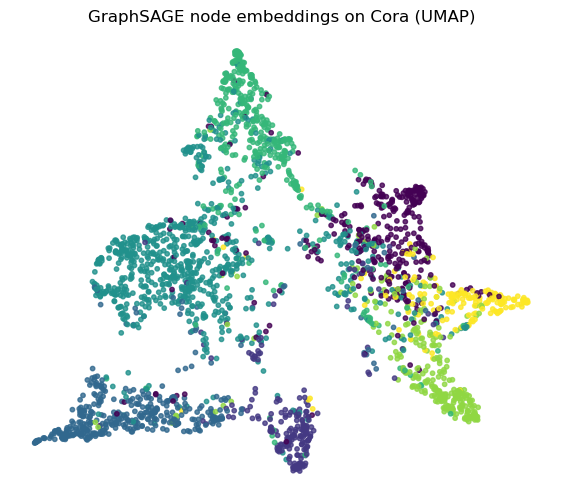

In [6]:
@torch.no_grad()
def get_node_embeddings(model, data):
    model.eval()
    # берём скрытое представление после первого слоя GraphSAGE
    x = model.conv1(data.x, data.edge_index)
    x = F.relu(x)
    return x.cpu().numpy(), data.y.cpu().numpy()

emb, labels = get_node_embeddings(model, data)
print("Embeddings shape:", emb.shape)
print("Labels shape:", labels.shape)

# стандартизируем перед UMAP
emb_scaled = StandardScaler().fit_transform(emb)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42,
)
emb_2d = reducer.fit_transform(emb_scaled)
print("UMAP 2D shape:", emb_2d.shape)

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=10,
    alpha=0.8,
)
plt.title("GraphSAGE node embeddings on Cora (UMAP)")
plt.axis("off")
plt.show()

In [7]:
np.save(ARTIFACTS_DIR / "embeddings_hidden.npy", emb)
np.save(ARTIFACTS_DIR / "embeddings_umap_2d.npy", emb_2d)
np.save(ARTIFACTS_DIR / "labels.npy", labels)

fig_path = ARTIFACTS_DIR / "umap_graphsage_cora.png"
plt.figure(figsize=(7, 6))
plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=labels,
    s=10,
    alpha=0.8,
)
plt.title("GraphSAGE node embeddings on Cora (UMAP)")
plt.axis("off")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.close()

print("Saved embeddings and UMAP figure to:", ARTIFACTS_DIR)

Saved embeddings and UMAP figure to: D:\ML\GNN\artifacts\cora_graphsage


## Conclusion

In this notebook we trained a **GraphSAGE** model on the Cora citation network and compared it to the GCN baseline.

Key results:

- Best validation accuracy: **~0.78**
- Test accuracy at the best validation epoch: **~0.81**

These numbers are slightly below the GCN baseline (~0.81 / ~0.83), which is expected on a small, homophilic benchmark like Cora where classical GCNs are very well aligned with the data. Nevertheless, GraphSAGE:

- still achieves strong performance on node classification,
- learns meaningful latent node embeddings (as confirmed by UMAP visualization),
- and, most importantly, is designed to scale to **much larger graphs** via neighborhood sampling and mini-batch training.

All artifacts (best model, hidden embeddings, UMAP projection and figure) were saved to `artifacts/cora_graphsage`.

## What we achieved

✔ Implemented a 2-layer GraphSAGE encoder (`SAGEConv` with mean aggregation)  
✔ Trained and evaluated the model on the Cora Planetoid split  
✔ Logged the training dynamics over 200 epochs  
✔ Extracted hidden node embeddings and visualized them with **UMAP**  
✔ Saved embeddings and plots for later analysis (`artifacts/cora_graphsage`)  
✔ Built a second, conceptually different GNN baseline to compare with GCN

## Interpretation

On Cora, GraphSAGE:

- does **not outperform** GCN in terms of accuracy,
- but provides a more flexible framework that naturally extends to:
  - mini-batch training,
  - large-scale graphs (millions of nodes / edges),
  - inductive settings (generalizing to unseen nodes/graphs).

In other words, Cora is a small didactic testbed, while GraphSAGE is primarily a **tool for real-world, large graph scenarios**.

## Next steps

In the following notebooks we will:

1. Train **GAT** (Graph Attention Networks) on Cora to explore attention-based neighbor weighting.
2. Try **GIN** as a more expressive message-passing architecture.
3. Implement **link prediction** with an encoder–decoder setup (preparation for recommender systems).
4. Experiment with **neighbor sampling** for GraphSAGE on larger or synthetic graphs.
5. Move towards a realistic **user–item graph recommender** project based on GraphSAGE.